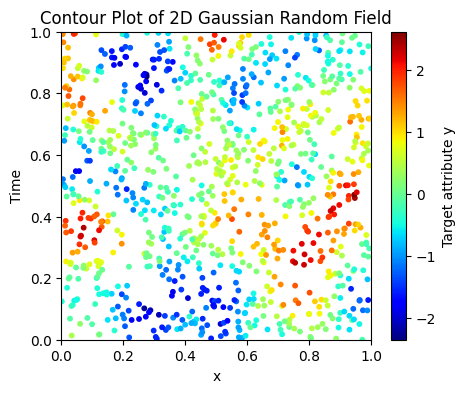

In [6]:
from time import gmtime, strftime
from tqdm import tqdm

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output
import IPython
# %matplotlib qt
import seaborn as sns

# import stream_generator
import learning_models
from datasets.data_loader import load_dataset


import neural_net_base_learner
# import wandb
import os
from utility.utilities import Logger, Plotter
from utility.sample import Sample


def generate_2d_gaussian_random_field(num_points, scale):
    # Sample x and y randomly
    x = np.random.uniform(0, 1, num_points)
    t = np.random.uniform(0, 1, num_points)
    
    # Compute the distance matrix
    d = np.sqrt((x[:, None] - x[None, :])**2 + (t[:, None] - t[None, :])**2)
    
    # Define the covariance function
    covariance_func = np.exp(-d**2 / (2 * scale**2))
    
    # Generate the random field
    mean = np.zeros(num_points)
    y = np.random.multivariate_normal(mean, covariance_func)
    y = y + np.random.normal(0, .2, num_points)
    return x, t, y

def generate_2_class_field(num_points):
    # Sample x and y randomly
    x = np.random.uniform(1, 2, num_points)
    t = np.random.uniform(0, 1, num_points)
    
    # Generate the random field
    y = np.ones(num_points)
    for i in range(num_points):
        if 2*x[i] - int(2*x[i]) > 0.5:
        # if x[i]+t[i] > 1:
            y[i] = -1
    y = y + np.random.normal(0, .0, num_points)
    return x, t, y

def generate_2d_abrupt_drift_field(num_points):
    # Sample x and y randomly
    x = np.random.uniform(1, 2, num_points)
    t = np.random.uniform(0, 1, num_points)
    
    # Generate the random field
    y = np.ones(num_points)
    for i in range(num_points):
        if t[i] > 0.5 and x[i] < 1:
        # if t[i] > 0.5:
        # if x[i]+t[i] > 1:
            y[i] = -1
            # print(y[i],i)
    y = y + np.random.normal(0, 0.3, num_points)
    return x, t, y


# Parameters
num_points = 1000  # Number of points to sample
scale = 0.1  # Scale of the correlation

# Generate field
x1, t1, y1 = generate_2d_gaussian_random_field(num_points, scale)
# x2, t2, y2 = generate_2_class_field(int(num_points/0.5))
# x2, t2, y2 = generate_2d_gaussian_random_field(num_points, scale)


# # combine the data into one dataset
# x = np.concatenate((x1, x2+1))
# t = np.concatenate((t1, t2))
# y = np.concatenate((y1, y2))


x, t, y = generate_2d_abrupt_drift_field(num_points)
x = x1
t = t1
y = y1

num_samples = len(x)
# Make a stream of samples
stream = []
for i in range(num_samples):
    stream.append((x[i], y[i], t[i], None))
# sort samples in the stream by time
stream.sort(key=lambda sample: sample[2])

%matplotlib inline
# Create a contour plot
plt.figure(figsize=(5, 4))
# plt.tricontourf(x, t, y, levels=20, cmap='viridis')
# plt.colorbar(label='Target attribute y')
vmin = min(y)
vmax = max(y)
plt.scatter(x, t, c=y, s=10, cmap='jet',vmin=vmin, vmax=vmax)
plt.colorbar(label='Target attribute y')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Contour Plot of 2D Gaussian Random Field')
plt.xlabel('x')
plt.ylabel('Time')
plt.show()


## Offline prediction test

In [30]:
from sklearn.ensemble import RandomForestRegressor
from dth import DTH

online_model = DTH(epsilon=0.9, prior=0.5)
# online_model.base_learner = neural_net_base_learner.RegressionNN(    hidden_layers=[50, 50, 50, 50, 50, 20, 10],
#                                                                 input_dim=2, 
#                                                                 output_dim=1,
#                                                                 dropout=0.05, 
#                                                                 learning_rate=0.1, 
#                                                                 epochs=200)

online_model.base_learner = RandomForestRegressor(n_estimators=50, max_depth=7, n_jobs=-1, bootstrap=True, max_samples=0.1)
# get X_with_time from stream
X_with_time = np.array([[sample[0], sample[2]] for sample in stream])
y = np.array([sample[1] for sample in stream])
online_model.base_learner.fit(X_with_time, y)

# make X_test with t=0 to 1 and x=0 to 1
X_test = np.linspace(0, 1, 100)
T_test = np.linspace(0, 1, 100)
X_test, T_test = np.meshgrid(X_test, T_test)
X_test = X_test.flatten()
T_test = T_test.flatten()
X_test_with_time = np.array([[x, t] for x, t in zip(X_test, T_test)])
y_pred = online_model.base_learner.predict(X_test_with_time)
y_pred = y_pred.reshape(100, 100)

# Create a contour plot
plt.figure(figsize=(5, 4))
contourf = plt.contourf(X_test.reshape(100, 100), T_test.reshape(100, 100), y_pred, levels=20, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(contourf, label='Predicted attribute y')

In [14]:
%matplotlib qt
from dth import DTH
from baselines_v2 import kswin_reg
from sklearn.ensemble import RandomForestRegressor
plt.close('all')
plt.figure(figsize=(4.5, 4.9))


online_model = DTH(epsilon=.9, prior=0.5)
# online_model = kswin_reg.KSWIN()
# dth = kswin_reg.KSWIN()

online_model.base_learner = RandomForestRegressor(n_estimators=20, max_depth=5, n_jobs=-1, bootstrap=True, max_samples=0.5)
# online_model.base_learner = neural_net_base_learner.RegressionNN(    hidden_layers=[250, 50, 50, 250],
#                                                                 input_dim=2, 
#                                                                 output_dim=1,
#                                                                 dropout=0.0, 
#                                                                 learning_rate=0.01, 
#                                                                 epochs=500)
y_pred = []
stream = np.array(stream)
samples_in_memory = []



# # make 100 grid points in time-space (t=0 to 1, x=0 to 1) to predict the field
# X_test_ = np.linspace(0, 1, 500)
# T_test_ = np.linspace(0, 1, 500)



for i, (X, y, t, y_pred) in enumerate(tqdm(stream)):
    
    X_with_time = np.append(t,X).reshape(1,-1)

    stream[i,3] = online_model.predict_online_model(X_with_time)[0]
    # print(X_with_time, y, stream[i,3])
    # dth.add_sample(X_with_time, y)

    online_model.update_online_model(X_with_time, y)

    
    # make 100 random points in time-space (t=0 to 1, x=0 to 1) to predict the field
    X_test = np.random.uniform(0, 1, 200)
    T_test = np.random.uniform(0, t, 200)

    # include the corner points of the time-space to the test points
    X_test = np.append(X_test, [0, 0, 1, 1])
    T_test = np.append(T_test, [0, t, 0, t])


    X_test_with_time = np.array([[t, x] for x, t in zip(X_test, T_test)]) 
    y_pred_contour = online_model.base_learner.predict(X_test_with_time)


    # print(y_pred_contour)    

    if i > 1:
        plt.cla()
        # if 'cbar' in locals():  # Check if colorbar was previously created
        #     cbar.remove()  # Remove the previous colorbar

        # draw hline at t
        plt.axhline(t, color='r', linestyle='--', lw=1)
        contourf = plt.tricontourf(X_test, T_test, y_pred_contour, levels=50, cmap='jet', vmin=vmin, vmax=vmax, alpha=0.5)
        plt.scatter(online_model.get_X(with_time=False).squeeze(), online_model.get_t(), c=online_model.get_y(), s=10, cmap='jet',vmax=vmax, vmin=vmin, edgecolors='g', linewidths=0.5)
        


        # cbar = plt.colorbar(contourf)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title('Number of samples in memory: {}'.format(online_model.get_num_samples()) + '\n Total recieved samples: {}'.format(i))
        plt.pause(0.01)
    


# calculate the error
y_pred = stream[:,3]
y_true = stream[:,1]
error = np.abs(y_true - y_pred)
print('Mean Absolute Error: ', np.mean(error))

    

 27%|██▋       | 266/1000 [01:10<03:15,  3.76it/s]


KeyboardInterrupt: 

In [16]:
# set back theme to dark
sns.set_theme(style="whitegrid")


plt.subplot(1, 2, 1)
plt.scatter(stream[:,0], stream[:,2], c=stream[:,1], s=10, cmap='jet',vmax=vmax, vmin=vmin)
plt.title('Actual values')
plt.xlabel('x')
plt.ylabel('Time')

plt.subplot(1, 2, 2)
plt.scatter(stream[:,0], stream[:,2], c=stream[:,3], s=10, cmap='jet',vmax=vmax, vmin=vmin)
plt.title('Predicted values')
plt.xlabel('x')
plt.ylabel('Time')
plt.tight_layout()
plt.show()

In [15]:
plt.plot(samples_in_memory)